# Classification of reconstructed images

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.fft import fft2, ifft2, fft, ifft

import torchvision.transforms as transforms
import torch
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Classify import CNN
import confusion_matrix as cm

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [4]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Load MNIST Data

In [6]:
%%time
# define hyperparameters
params = {
  "dataset": "reconstructed_MNIST",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 50,
  "p": 23, # size of array (has to be prime)
  "image_size": 23,
  "kernel_size": 3,
  "kind": "classification",
  "suffix": "reconstructed",
}
params['model'] = params['kind']+'_' + params['suffix'] 
params['model_save_path'] = f'../models/{params["kind"]}/{params["model"]}.pth'

# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])
wandb.config = params

CPU times: user 1.96 ms, sys: 69 µs, total: 2.03 ms
Wall time: 2.01 ms


In [7]:
# define CNN and get data
model = CNN(params)
train_data, eval_data, test_data, loaders = CNN.load_reconstructed_data(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 
#PATH = f'../models/mnist_{params["epochs"]}epochs.pth'

Number of elements in each dataset 
Training: 56000 
Validation: 7000 
Testing: 7000


## Train

In [8]:
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, project="coded-aperture-MNIST", group=model.params["kind"], name=f"{model.params['model']}_exp1")

for epoch in range(params['epochs']):

    running_loss = 0.0
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [encoded image, original image, reconstructed image, digit label]
        encoded_img_batch, og_img_batch, recon_img_batch, digit_batch = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(recon_img_batch)
        loss = criterion(outputs, digit_batch)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
        wandb.log({"epoch": epoch, "loss": running_loss})
print('Finished Training')
# Save model

wandb.finish()
torch.save(model.state_dict(), model.params['model_save_path'])

[1,   100] loss: 0.084
[1,   200] loss: 0.043
[1,   300] loss: 0.031
[1,   400] loss: 0.022
[1,   500] loss: 0.017
[2,   100] loss: 0.014
[2,   200] loss: 0.013
[2,   300] loss: 0.012
[2,   400] loss: 0.010
[2,   500] loss: 0.010
[3,   100] loss: 0.009
[3,   200] loss: 0.008
[3,   300] loss: 0.008
[3,   400] loss: 0.008
[3,   500] loss: 0.007
[4,   100] loss: 0.006
[4,   200] loss: 0.007
[4,   300] loss: 0.007
[4,   400] loss: 0.006
[4,   500] loss: 0.006
[5,   100] loss: 0.005
[5,   200] loss: 0.005
[5,   300] loss: 0.006
[5,   400] loss: 0.005
[5,   500] loss: 0.005
[6,   100] loss: 0.005
[6,   200] loss: 0.004
[6,   300] loss: 0.005
[6,   400] loss: 0.005
[6,   500] loss: 0.004
[7,   100] loss: 0.004
[7,   200] loss: 0.004
[7,   300] loss: 0.004
[7,   400] loss: 0.004
[7,   500] loss: 0.004
[8,   100] loss: 0.003
[8,   200] loss: 0.003
[8,   300] loss: 0.003
[8,   400] loss: 0.003
[8,   500] loss: 0.004
[9,   100] loss: 0.003
[9,   200] loss: 0.003
[9,   300] loss: 0.003
[9,   400] 

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.6717


## Evaluate

In [8]:
# Load model if one is not loaded already
model.load_state_dict(torch.load(params['model_save_path']))

<All keys matched successfully>

### One batch

In [11]:
# Define data iterator to get testing data in batches
dataiter = iter(loaders['test'])
images, labels = dataiter.next()

# Input image batch into model to get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

In [12]:
torch.nonzero(predicted != labels)

tensor([[18],
        [80]])

In [26]:
((predicted == labels) == False).nonzero()

/var/folders/00/mn_mr29n7s37xcf_4vdv1sc40000gn/T/ipykernel_5993/3193168444.py:1: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  ((predicted == labels) == False).nonzero()


tensor([[18],
        [80]])

### ALL test set

In [9]:
# Initialize variables
correct = 0
total = 0
incorrect_examples = []
predicted_all = []
labels_all = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        # get images and labels from test set
        _, _, images, labels = data
    
        # calculate outputs by running images through the network (done in batches)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        idxs_mask = torch.nonzero(predicted != labels) #((predicted == labels) == False).nonzero()
        for single_sample in idxs_mask:
            incorrect_examples.append([np.squeeze(images[single_sample].numpy()), 
                                       labels[single_sample].numpy()[0], 
                                       predicted[single_sample].numpy()[0]])
        predicted_all.append(predicted.tolist())
        labels_all.append(labels.tolist())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

predicted_all = list(np.concatenate(predicted_all).flat) 
labels_all = list(np.concatenate(labels_all).flat) 

Accuracy of the network on the 7000 test images: 97.2 %


## Confusion Matrix

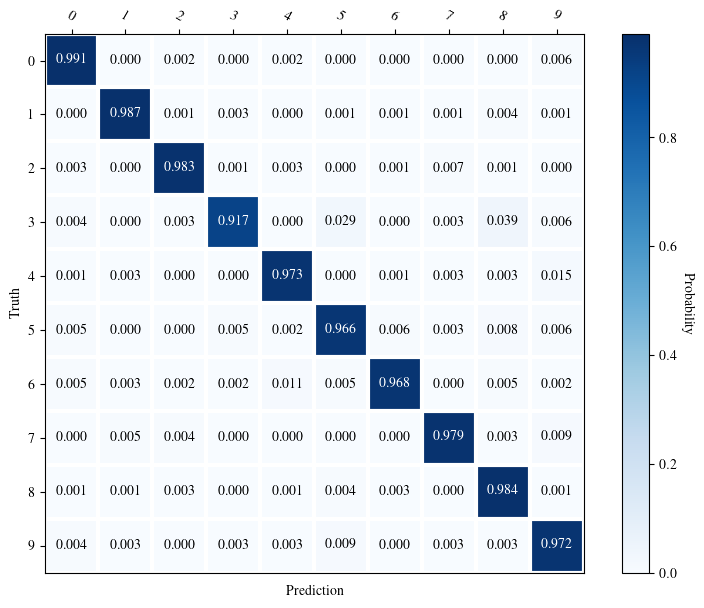

In [10]:
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")

## Class-specific accuracy

In [11]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        _, _, images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.3f} %')

Accuracy for class:     0 is 99.096 %
Accuracy for class:     1 is 98.708 %
Accuracy for class:     2 is 98.312 %
Accuracy for class:     3 is 91.655 %
Accuracy for class:     4 is 97.331 %
Accuracy for class:     5 is 96.584 %
Accuracy for class:     6 is 96.784 %
Accuracy for class:     7 is 97.898 %
Accuracy for class:     8 is 98.375 %
Accuracy for class:     9 is 97.226 %


# Missclassifications

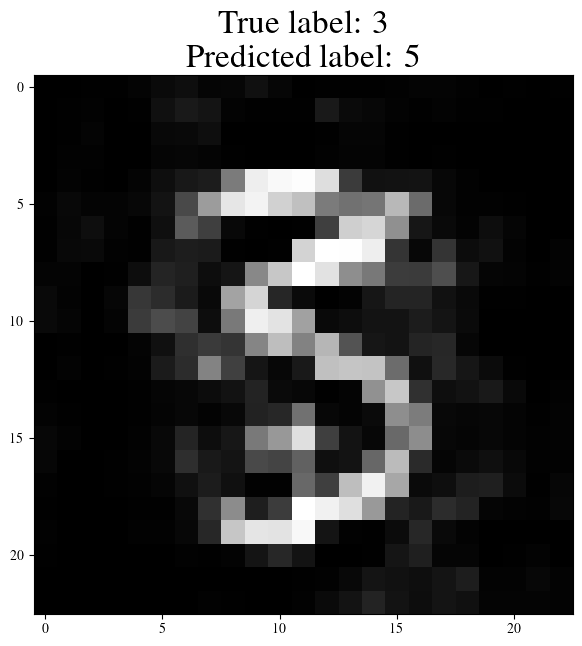

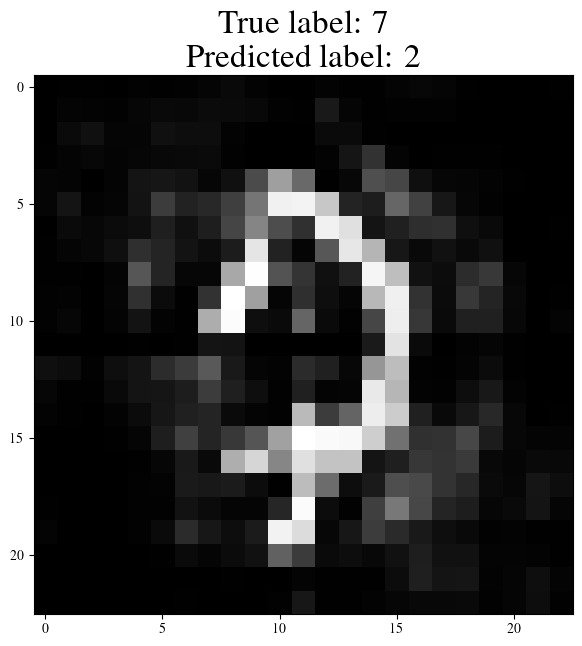

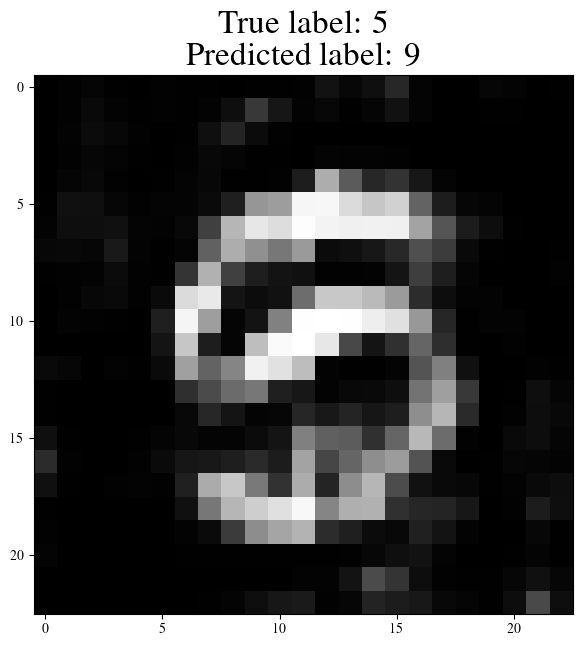

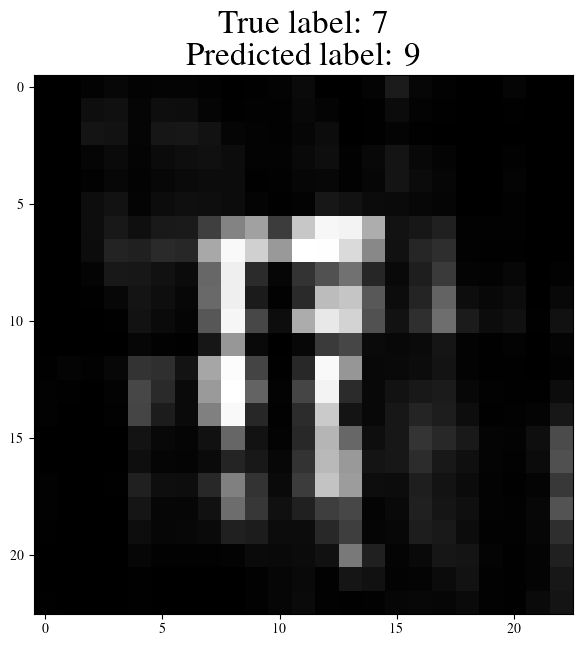

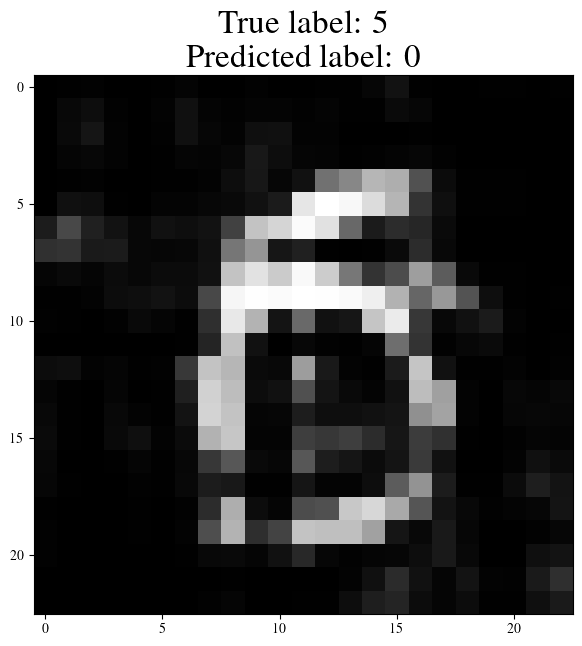

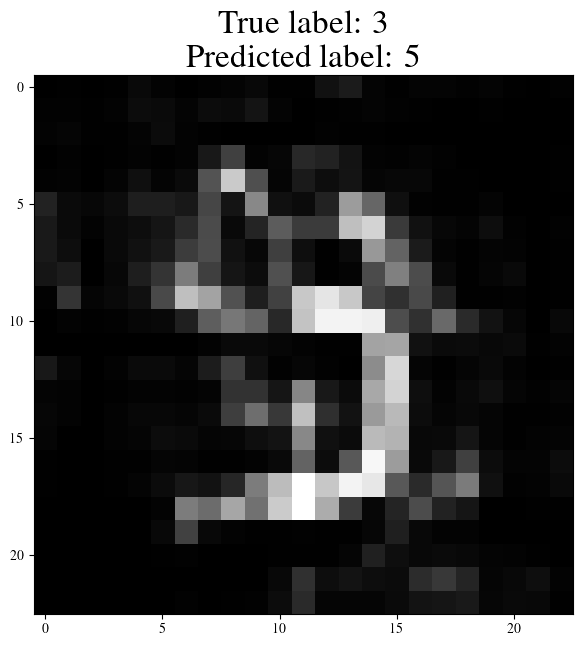

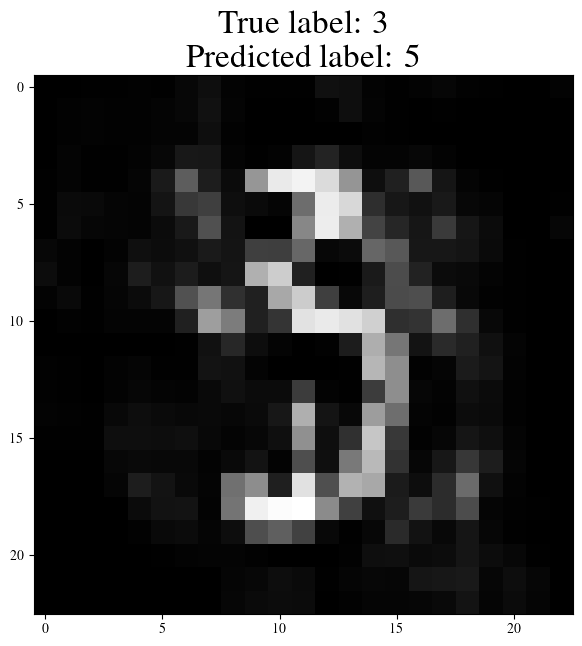

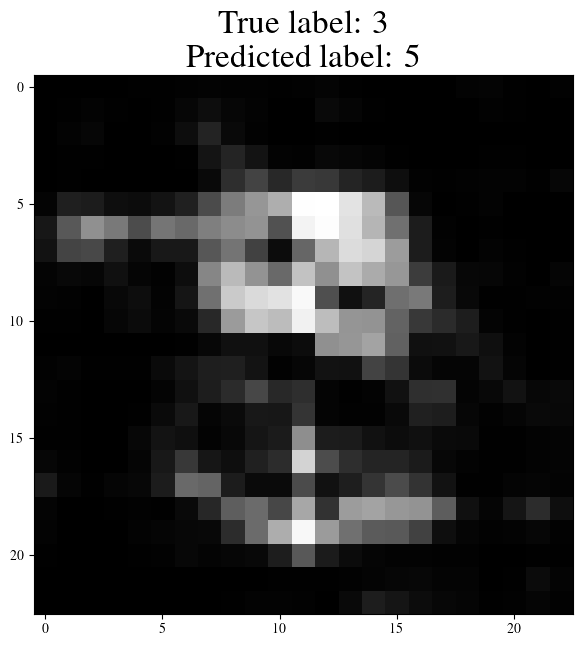

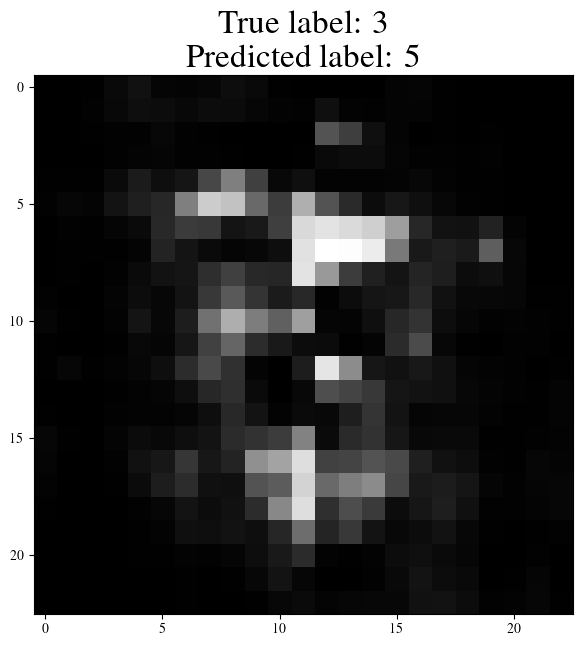

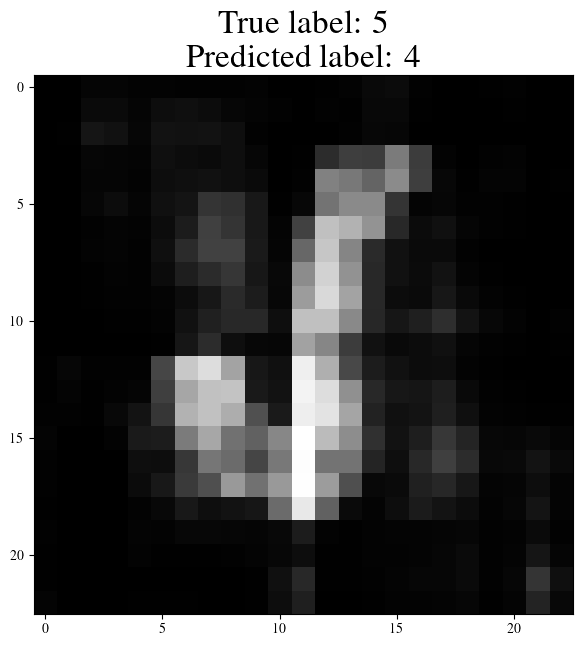

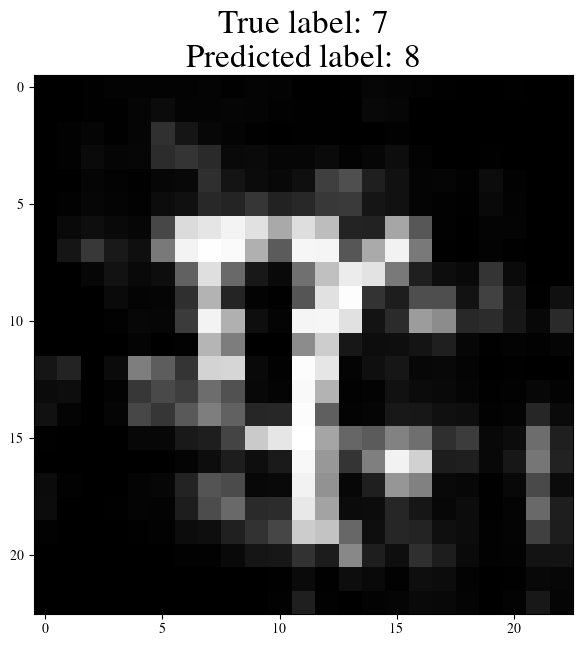

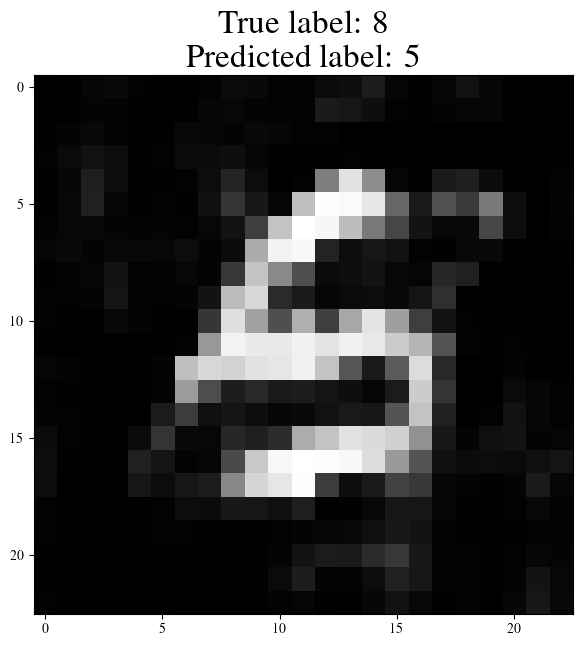

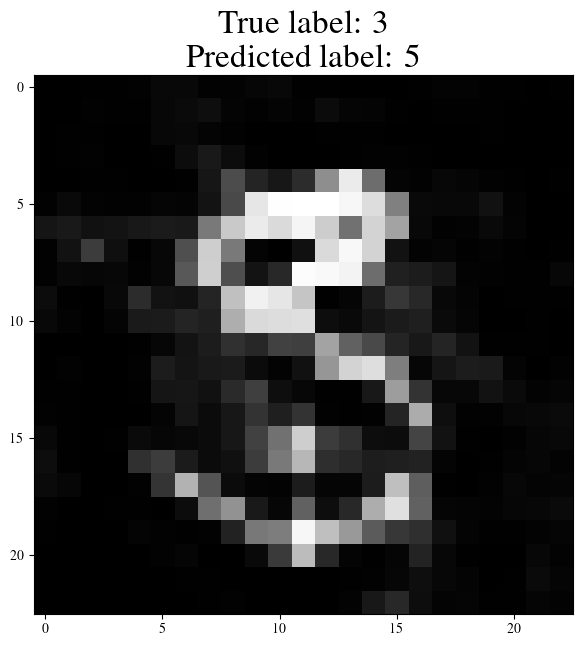

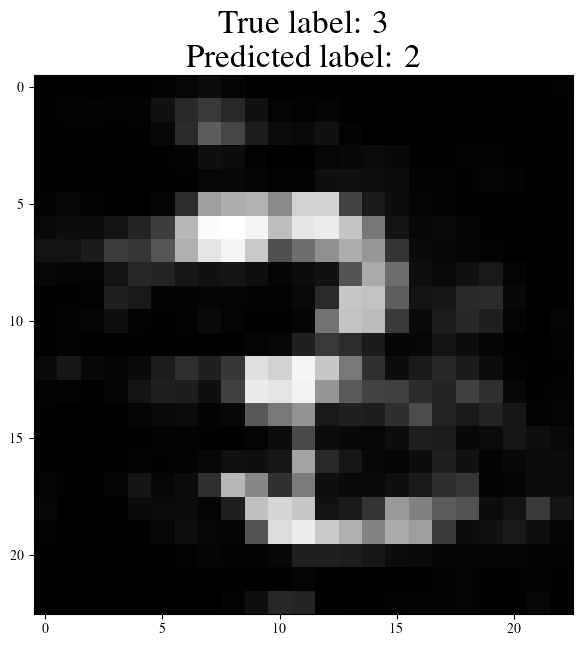

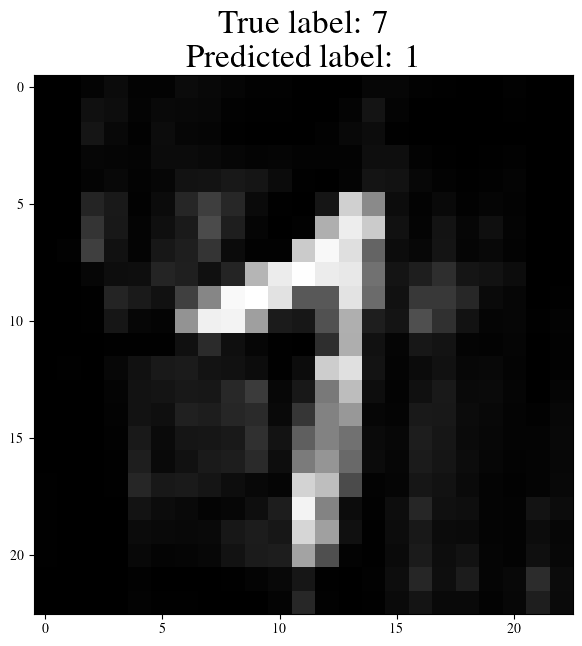

In [12]:
#index = 1
FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"

cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    img = np.squeeze(incorrect_examples[index][0])
    #true_img = mura.FFT_convolve(img, G)
    true_lab = incorrect_examples[index][1]
    pred_lab = incorrect_examples[index][2]

    if true_lab in [5,7,3,8,9]:
        #fig, axs = plt.subplots(2,1, figsize=(5,12))
        #axs = axs.ravel()
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs[0].imshow(true_img, cmap=cmap)
        axs.imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[0].set_title(f"Original Image", fontsize=24)
        #fig.savefig(FIG_FOLDER + f"misclass_encoded_{index}.png")
        plt.show() 

In [13]:
# Save dataframe with misclassifications
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])
df.head()

,image_array,label,prediction
0,"[[0.00022988931, 0.0009000885, 0.0069202464, 0...",7,1
1,"[[0.001034866, 0.0015656466, 0.0033158516, 0.0...",3,8
2,"[[0.0007640273, 0.005516173, 0.0067891087, 0.0...",9,0
3,"[[0.00078078214, 0.0022791852, 0.004652952, 0....",1,2
4,"[[0.0006282066, 0.0020745087, 0.0017357375, 0....",3,0


In [14]:
df.label.value_counts(normalize=True)

3    0.306122
5    0.112245
6    0.107143
9    0.096939
4    0.096939
7    0.081633
2    0.061224
8    0.056122
1    0.051020
0    0.030612
Name: label, dtype: float64

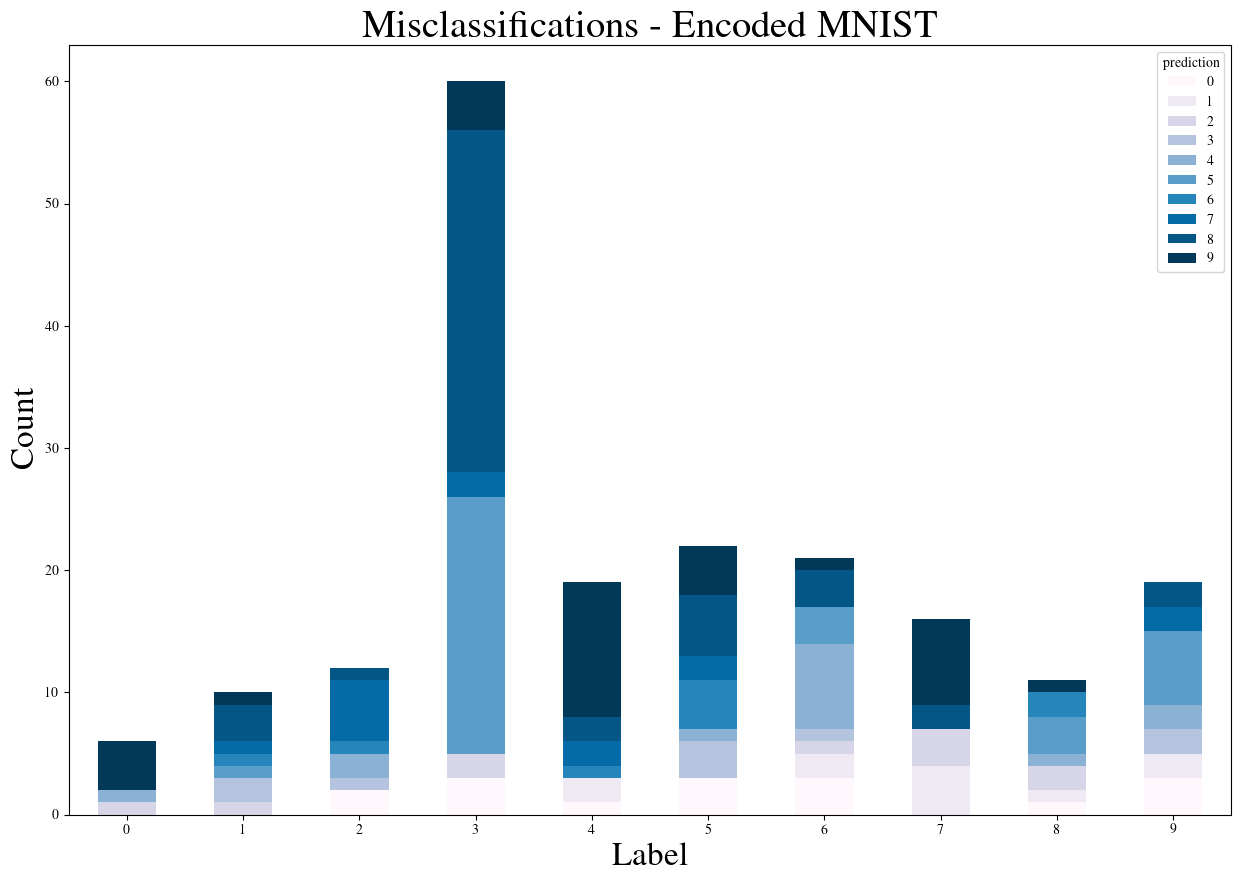

prediction  0  1  2  3  4   5  6  7   8   9
label                                      
0           0  0  1  0  1   0  0  0   0   4
1           0  0  1  2  0   1  1  1   3   1
2           2  0  0  1  2   0  1  5   1   0
3           3  0  2  0  0  21  0  2  28   4
4           1  2  0  0  0   0  1  2   2  11
5           3  0  0  3  1   0  4  2   5   4
6           3  2  1  1  7   3  0  0   3   1
7           0  4  3  0  0   0  0  0   2   7
8           1  1  2  0  1   3  2  0   0   1
9           3  2  0  2  2   6  0  2   2   0


In [16]:
fontsize = 28
crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=fontsize-4)
plt.xlabel("Label", fontsize=fontsize-4)
plt.title("Misclassifications - Encoded MNIST", fontsize=fontsize)
#plt.savefig("../figs/misclassifications_counts_reconstructed_mnist.png")
plt.show()
print(crosstab_misclass)

# Plotting/other

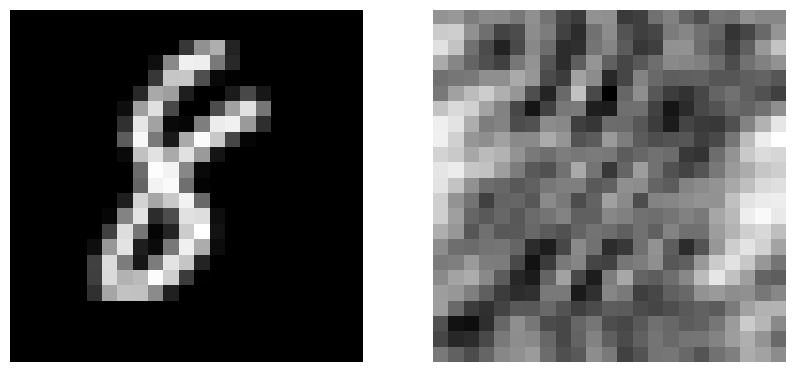

In [133]:
cmap = "gray"
index = 0
img = images[index][0]
true_img = mura.FFT_convolve(img.numpy(), G)
pred_lab = predicted[index]
true_lab = labels[index]

fig, axs = plt.subplots(1,2, figsize=(10,7))
axs = axs.ravel()

axs[0].imshow(true_img, cmap=cmap);
axs[1].imshow(img, cmap=cmap)

axs[0].axis('off') ; axs[1].axis('off')
#plt.savefig("../figs/true_img_coded_img_8.svg")
plt.show()

# To be deleted